In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [2]:
df = pd.read_csv("Train_Data.csv")
t_df = df.drop(columns = ['SEQN'])
t_df.head()

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [3]:
t_df['DIQ010'].unique()




array([ 2., nan,  1.,  3.])

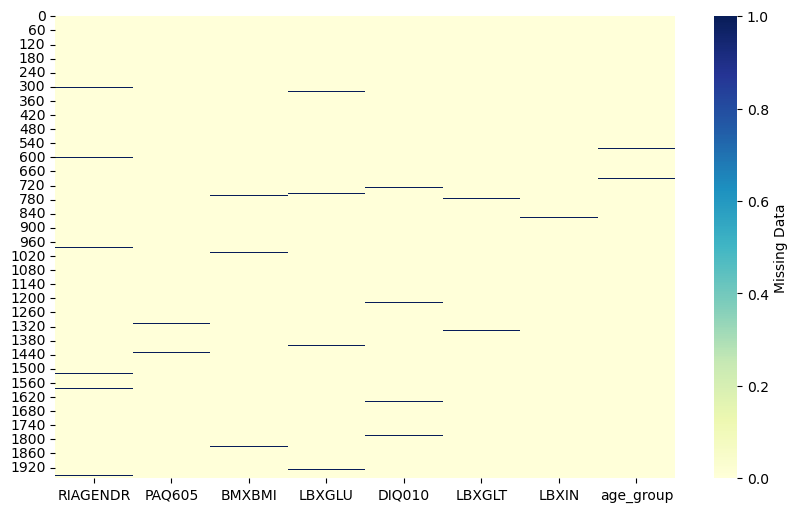

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(t_df.isna(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

In [5]:
t_df['age_group'] = t_df['age_group'].map({'Adult': 0, 'Senior': 1})

In [6]:
cols_to_impute = ['PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN']
df_impute = t_df[['RIAGENDR', 'age_group'] + cols_to_impute]

In [7]:
imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)
df_imputed = pd.DataFrame(imp.fit_transform(df_impute), columns=df_impute.columns)

In [8]:
t_df[cols_to_impute] = df_imputed[cols_to_impute]

In [9]:
from sklearn.impute import KNNImputer

features_for_gender = t_df[['RIAGENDR', 'BMXBMI', 'PAQ605', 'LBXGLU', 'LBXIN', 'DIQ010']]

knn_imp = KNNImputer(n_neighbors=5)
imputed_data = pd.DataFrame(knn_imp.fit_transform(features_for_gender), columns=features_for_gender.columns)

t_df['RIAGENDR'] = imputed_data['RIAGENDR'].round().astype(int)

In [10]:
features_for_age = t_df[['age_group', 'BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN', 'DIQ010']]

knn_age_imp = KNNImputer(n_neighbors=5)
imputed_age = pd.DataFrame(knn_age_imp.fit_transform(features_for_age), columns=features_for_age.columns)

t_df['age_group'] = imputed_age['age_group'].round().astype(int).map({0: 'Adult', 1: 'Senior'})

In [11]:
t_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RIAGENDR   1966 non-null   int32  
 1   PAQ605     1966 non-null   float64
 2   BMXBMI     1966 non-null   float64
 3   LBXGLU     1966 non-null   float64
 4   DIQ010     1966 non-null   float64
 5   LBXGLT     1966 non-null   float64
 6   LBXIN      1966 non-null   float64
 7   age_group  1966 non-null   object 
dtypes: float64(6), int32(1), object(1)
memory usage: 115.3+ KB


In [12]:
t_df['age_group'] = t_df['age_group'].map({'Adult': 0, 'Senior': 1})

In [13]:
X = t_df[[
    'RIAGENDR',
    'PAQ605',
    'BMXBMI',
    'LBXGLU',
    'DIQ010',
    'LBXGLT',
    'LBXIN',
]]
y = t_df['age_group']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

In [42]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.2 MB/s eta 0:00:00


In [15]:
from sklearn.utils import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

weight_dict = dict(zip(np.unique(y), class_weights))

In [741]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(
    learning_rate=0.05,
    reg_alpha=1,
    reg_lambda=1,
     max_depth=7,
    num_leaves=7,
      class_weight=weight_dict,
    n_estimators=1000,
    boosting_type='dart'

  )
clf.fit(X, y,   eval_metric='f1-score')

LGBMClassifier(boosting_type='dart',
               class_weight={0: 0.5957575757575757, 1: 3.1107594936708862},
               learning_rate=0.05, max_depth=7, n_estimators=1000, num_leaves=7,
               objective='binary', reg_alpha=1, reg_lambda=1)

In [742]:
y_probs = clf.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)
y_probs

array([0.4476366 , 0.25370254, 0.04013365, 0.74374368, 0.11307127,
       0.07765921, 0.07073581, 0.15296516, 0.32299985, 0.63561285,
       0.67534412, 0.17689087, 0.55147433, 0.69016685, 0.13159528,
       0.15247684, 0.06517808, 0.02811502, 0.0531134 , 0.2922608 ,
       0.10850611, 0.29230386, 0.6488978 , 0.74506136, 0.05920093,
       0.30089924, 0.08184402, 0.1889418 , 0.10548531, 0.15951233,
       0.63661136, 0.32334181, 0.05627526, 0.4026716 , 0.45920298,
       0.61529942, 0.75031305, 0.53516703, 0.71684421, 0.17254073,
       0.59786846, 0.67563876, 0.6840444 , 0.08864512, 0.35694089,
       0.36389448, 0.27170605, 0.51215983, 0.61052951, 0.77209157,
       0.24162349, 0.27653156, 0.15766724, 0.22635475, 0.76212451,
       0.64144578, 0.57806561, 0.10886899, 0.73300584, 0.05621329,
       0.46666205, 0.02031138, 0.66451257, 0.20268447, 0.63051059,
       0.20330158, 0.53851032, 0.27687578, 0.10264406, 0.42816225,
       0.29580359, 0.45479183, 0.07887151, 0.07353949, 0.63696

In [743]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8096


In [744]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.8015
Test set score: 0.8096


In [745]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       331
           1       0.45      0.87      0.59        63

    accuracy                           0.81       394
   macro avg       0.71      0.84      0.74       394
weighted avg       0.89      0.81      0.83       394



In [746]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

<Axes: >

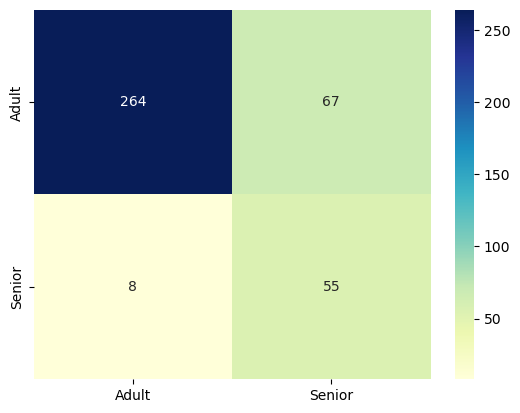

In [747]:
cm_matrix = pd.DataFrame(data=cm, columns=['Adult', 'Senior'], 
                                 index=['Adult', 'Senior'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [751]:
test_df = pd.read_csv('Test_Data.csv')
test_df.drop(columns = ['SEQN'],inplace=True)
test_df.head()

In [749]:
sub = pd.read_csv("Sample_Submission.csv")
sub

,age_group
0,0
1,0
2,0
3,0
4,0
...,...
307,1
308,1
309,1
310,1


In [752]:
test_pred = clf.predict(test_df)

In [753]:
result = pd.DataFrame(test_pred, columns=["age_group"])
result

,age_group
0,0
1,1
2,0
3,0
4,0
...,...
307,0
308,0
309,0
310,0


In [754]:
result.to_csv("Submission.csv")